In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.use('pgf')
matplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)
matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (4.01407, 3.09654)

'import matplotlib\nimport matplotlib.pyplot as plt\nfrom matplotlib.backends.backend_pgf import FigureCanvasPgf\n\nmatplotlib.use(\'pgf\')\nmatplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)\nmatplotlib.rcParams.update(\n    {\n        # Adjust to your LaTex-Engine\n        "pgf.texsystem": "xelatex",\n        "font.family": "serif",\n        "text.usetex": True,\n        "pgf.rcfonts": False,\n        "axes.unicode_minus": False,\n    }\n)\n\nmatplotlib.rcParams[\'figure.figsize\'] = (4.01407, 3.09654)'

In [3]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif")
oog.sequence_manager.reference_period = 73.106274
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\2024-04-26 17.30.44 vid bloodless 200fps\ref-frames-2024-04-26-17.29.51\*tif


Getting phases: 100%|██████████| 37970/37970 [00:00<00:00, 168036.27it/s]


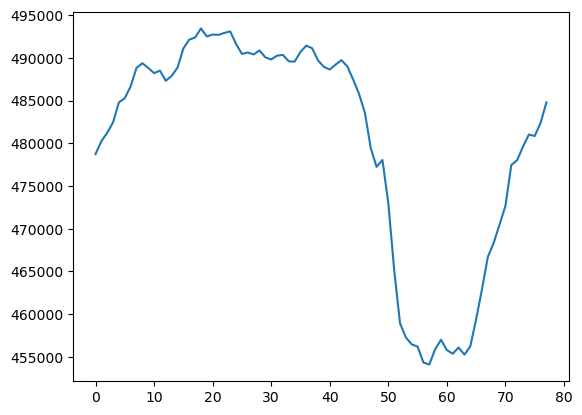

In [4]:
plt.plot(np.sum(np.abs(np.diff(oog.sequence_manager.reference_sequence.astype(np.int32))), axis = (1,2)))

In [5]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(OG.radsperframe_to_bps(np.array(gradients),120))


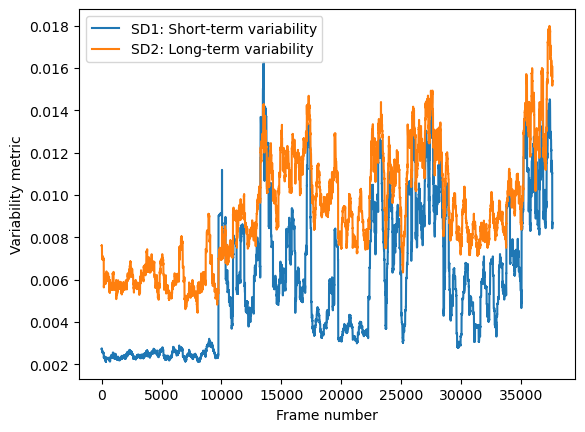

In [12]:
window = 300
sd1s = []
sd2s = []
for i in range(0, oog.delta_phases.shape[0] - window, 1):
    RR_1 = oog.delta_phases[i:i + window]
    RR_2 = oog.delta_phases[i + 1:i + window + 1]

    x_1 = (RR_1 - RR_2) / 2**(0.5)
    x_2 = (RR_1 + RR_2) / 2**(0.5)

    sd1 = np.sqrt(np.var(x_1))
    sd2 = np.sqrt(np.var(x_2))

    sd1s.append(sd1)
    sd2s.append(sd2)

plt.plot(sd1s, label = "SD1: Short-term variability")
plt.plot(sd2s, label = "SD2: Long-term variability")
plt.legend()
plt.ylabel("Variability metric")
plt.xlabel("Frame number")
plt.savefig("variability_sd1_sd2_bloodless.pgf")
plt.show()

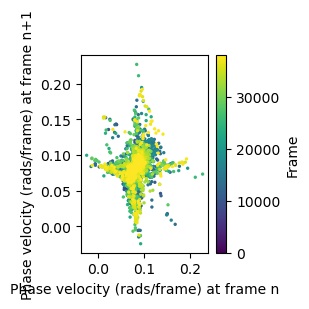

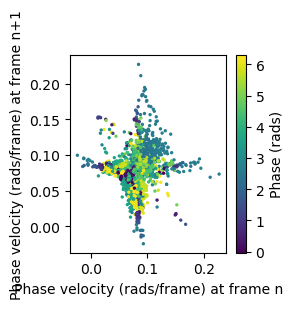

In [7]:
plt.figure(figsize = (3,3))
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], c = range(len(oog.delta_phases) - 1), s = 2, rasterized=True)
plt.colorbar(label = "Frame")
plt.xlabel("Phase velocity (rads/frame) at frame n")
plt.ylabel("Phase velocity (rads/frame) at frame n+1")
plt.tight_layout()
plt.savefig("poincare_bloodless_phase_delta.pgf")


plt.figure(figsize = (3,3))
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1::], c = oog.phases[2::], s = 2, rasterized=True)
plt.colorbar(label = "Phase (rads)")
plt.xlabel("Phase velocity (rads/frame) at frame n")
plt.ylabel("Phase velocity (rads/frame) at frame n+1")
plt.tight_layout()
plt.savefig("poincare_bloodless_frame_delta.pgf")

plt.show()

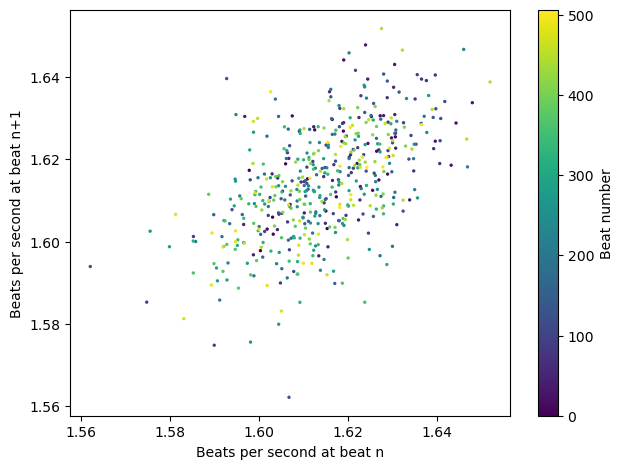

In [8]:
plt.figure()
plt.scatter(gradients[0:-1], gradients[1::], c = range(len(gradients) - 1), s = 2)
plt.colorbar(label = "Beat number")
plt.xlabel("Beats per second at beat n")
plt.ylabel("Beats per second at beat n+1")
plt.tight_layout()
plt.savefig("bps_scatter_bloodless.pgf")
plt.show()

In [9]:
RR_1 = gradients[0:-1]
RR_2 = gradients[1::]

x_1 = (RR_1 - RR_2) / 2**(0.5)
x_2 = (RR_1 + RR_2) / 2**(0.5)

sd1 = np.sqrt(np.var(x_1))
sd2 = np.sqrt(np.var(x_2))

print("SD1: ", sd1)
print("SD2: ", sd2)

SD1:  0.008947788048189086
SD2:  0.016587115250383824


In [10]:
RR_1 = oog.delta_phases[0:-1]
RR_2 = oog.delta_phases[1::]

x_1 = (RR_1 - RR_2) / 2**(0.5)
x_2 = (RR_1 + RR_2) / 2**(0.5)

sd1 = np.sqrt(np.var(x_1))
sd2 = np.sqrt(np.var(x_2))

print("SD1: ", sd1)
print("SD2: ", sd2)

SD1:  0.006770171984437693
SD2:  0.00969147405838282


In [11]:
print(np.where(oog.phases < 1))

(array([   57,    58,    59, ..., 37912, 37913, 37914], dtype=int64),)
